In [85]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import requests # for make API requests
from requests.exceptions import HTTPError# to handle the responses

import networkx as nx #for make protein networks

import import_ipynb #for import own functions

import time #to calculate the time

Получение списков генов с повышенной и пониженной экспрессией для запроса в базу STRING и создания сети белок-белковых взаимодействий. 

In [86]:
from function_signature_from_DE import make_signature_from_DE #from previous task

In [87]:
help(make_signature_from_DE)

Help on function make_signature_from_DE in module function_signature_from_DE:

make_signature_from_DE(file, logFC=(-1, 1), pvalue=0.01)
    find genes with increased and decreased expression
    
    Parametrs
    ---------
    file: the path to the file with differential expression results (DESeq2, EdgeR)
    logFC: a tuple with a lower and upper threshold for log2 fold change
    pvalue: threshold for pvalue
    
    Return
    ------
    a tuple with 2 lists: 1) list of genes with increased expression - genes with a logarithm of the fold change greater than 
                            set upper threshold for logFC, pvalue less than threshold for pvalue
                          2) list of genes with reduced  expression - genes with a logarithm of the fold change less than 
                            set lower threshold for logFC, pvalue less than threshold for pvalue
    Each list of genes is sorted decrease of the modulo the logarithm of the fold change and sorted by increasing p

In [88]:
def get_list_protein_in_STRING(gene_set, number = 2000, species = 9606):
    """
    find a list of genes whose proteins are in the database STRING
    
    Parametrs
    ---------
    gene_set: set of genes
    number: the number of genes you want to get. These genes are selected from the beginning of the submitted list of genes 
    with the condition that their protein must be in the database STRING
    species: NCBI taxon identifiers (e.g. Human is 9606)
    
    Return
    ------
    a tuple with 2 lists: 1) list of genes selected from the beginning of the submitted list of genes and 
                            their proteins are in the database STRING
                          2) list of genes selected from the beginning of the submitted list of genes and 
                            their proteins are not in the database STRING
    """

    string_api_url = "https://string-db.org/api"
    output_format = "tsv-no-header"
    method = "network"

    request_url = "/".join([string_api_url, output_format, method])
    
    list_proteins_in_STRING = []
    list_proteins_not_in_STRING = []
    i = 0
    number_proteins_in_STRING = 0
    while (number_proteins_in_STRING  < number):
        gene = gene_set[i]
        i += 1
        params = {

            "identifiers" : gene, # your protein
            "species" : species, # species NCBI identifier 
            "caller_identity" : "www.awesome_app.org" # your app name

        }

        response = requests.post(request_url, data = params)
        
        try:
            response.raise_for_status()
            list_proteins_in_STRING.append(gene)
            number_proteins_in_STRING = len(list_proteins_in_STRING)
        except HTTPError as http_err:
            list_proteins_not_in_STRING.append(gene)

    return (list_proteins_in_STRING, list_proteins_not_in_STRING)

In [89]:
def get_signature_for_request_in_STRING(file, logFC = (-1, 1), pvalue = 0.01, number = 2000, species = 9606):
    """
    Find genes with increased and decreased expression from file with differential expression results. 
    First these genes are selected from file with DE results by logarithm of the fold change and pvalue.
    Second these genes sorted by decrease of the modulo the logarithm of the fold change and sorted by increasing pvalue.
    Third the desired number of genes with the highest modulo the logarithm of the fold change and lowest pvalue is selected 
    with the condition that their protein must be in the database STRING.
    
    Parametrs
    ---------
    file: the path to the file with differential expression results (DESeq2, EdgeR)
    logFC: a tuple with a lower and upper threshold for log2 fold change
    pvalue: threshold for pvalue
    number: the number of genes with increased or decreased expression you want to get.
    species: NCBI taxon identifiers (e.g. Human is 9606)
    
    Return
    ------
    a tuple with 2 lists: 1) list of genes with increased expression - genes with a logarithm of the fold change greater than 
                            set upper threshold for logFC, pvalue less than threshold for pvalue.
                            List consist of genes that have the highest the logarithm of the fold change and lowest pvalue.
                            List is sorted by decrease of the modulo the logarithm of the fold change and sorted by
                            increasing pvalue. Proteins of these genes are in the database STRING.
                          2) list of genes with decreased expression - genes with a logarithm of the fold change less than 
                            set down threshold for logFC, pvalue less than threshold for pvalue.
                            List consist of genes that have the lowest the logarithm of the fold change and lowest pvalue.
                            List is sorted by decrease of the modulo the logarithm of the fold change and sorted by
                            increasing pvalue. Proteins of these genes are in the database STRING.
    """
    # find genes with increased and decreased expression from DE file by the threshold values
    data_up_genes, data_down_genes = make_signature_from_DE(file, logFC, pvalue) 
    
    # select genes whose proteins are in the database STRING
    proteins_up_in_STRING = get_list_protein_in_STRING(data_up_genes, number, species)[0]
    proteins_down_in_STRING = get_list_protein_in_STRING(data_down_genes, number, species)[0]
    return (proteins_up_in_STRING, proteins_down_in_STRING)

In [91]:
start_time = time.time()
signature = get_signature_for_request_in_STRING("DATA/DE_heart_fibroblast/DE_with_edgeR_for_heart_fibroblast.txt", (-1, 1), 0.01, 2000)
print("--- %s seconds ---" % (time.time() - start_time))

--- 1297.0930724143982 seconds ---


In [92]:
with open("list_proteins_up_in_STRING_2000.txt", "w") as file:
        file.write("%0d".join(signature[0]))
with open("list_proteins_down_in_STRING_2000.txt", "w") as file:
        file.write("%0d".join(signature[1]))

In [93]:
print("number genes in down and up:", len(signature[0]), "и", len(signature[1]))

number genes in down and up: 2000 и 2000


# Построение сети белок-белковых взаимодействий.

Напишем класс, используя pandas DataFrames для создания матрицы смежности и графа.

In [107]:
class Interactions_dataframe:
    """
    class Interactions is designed to represent STRING protein-protein interaction network in different forms: adjacency matrix, graph
    
    Attributes
    ----------
    signature: a tuple with list of genes with increased expression and list of genes with decreased expression
    up_genes : a list of genes with increased expression
    down_genes: a list of genes with decreased expression
    species: NCBI taxon identifiers (e.g. Human is 9606)
    experimental_score_threshold: threshold for combined score. It's computed by combining the probabilities from 
    the different evidence channels and corrected for the probability of randomly observing an interaction.

    Methods
    -------
    API_request(expression_change)
        requests STRING interaction network for multiple proteins
        
    get_interactions_as_adjacency_matrix(expression_change)
        builds an adjacency matrix for the interaction network

    get_interactions_as_graph(expression_change)
        builds a graph for the interaction network
        
    draw_network_ineractions(expression_change)
        draw the interaction network
    
    save_draw_network_ineractions(expression_change, file_name)
    
    save_adjacency_matrix(expression_change, file_name)
        save adjacency_matrix in csv file format
        
    save_graph(expression_change, file_name)
        save graph in multiline adjacency list format to path
    """
    def __init__(self, signature, species, experimental_score_threshold):
        self.signature = signature
        self.up_genes = signature[0]
        self.down_genes = signature[1]
        self.species = species
        self.experimental_score_threshold = experimental_score_threshold
        
    def API_request(self, expression_change):
        if expression_change:
            gene_set = self.up_genes
        else:
            gene_set = self.down_genes
            
        string_api_url = "https://string-db.org/api"
        output_format = "tsv-no-header"
        method = "network"
        
        request_url = "/".join([string_api_url, output_format, method])
        params = {

            "identifiers" : "%0d".join(gene_set), # your protein
            "species" : self.species, # species NCBI identifier 
            "caller_identity" : "www.awesome_app.org" # your app name

        }
        
        response = requests.post(request_url, data = params)
        return response
    
    def get_interactions_as_adjacency_matrix(self, expression_change):
        if expression_change:
            gene_set = self.up_genes
        else:
            gene_set = self.down_genes
        
        response = self.API_request(expression_change)
        
        zero_array = np.zeros(shape=(len(gene_set), len(gene_set)))
        pd_as_adjacency_matrix = pd.DataFrame(zero_array)
        pd_as_adjacency_matrix.index = gene_set
        pd_as_adjacency_matrix.columns = gene_set
        
        
        try:
            response.raise_for_status()
            for line in response.text.strip().split("\n"):

                l = line.strip().split("\t")
                p1, p2 = l[2], l[3]
                
                ## filter the interaction according to experimental score
                experimental_score = float(l[10])
                if experimental_score > self.experimental_score_threshold:
                    if ((p1 in gene_set) & (p2 in gene_set)):
                        pd_as_adjacency_matrix.loc[p1, p2] = 1
                        pd_as_adjacency_matrix.loc[p2, p1] = 1
            return pd_as_adjacency_matrix
        except HTTPError as http_err:
            print(f'some problems with querying the STRING database. More precisely HTTP error occurred: {http_err}') 
            print(f'answer database STRING: {response.text}')
            
    def get_interactions_as_graph(self, expression_change):
        pd = self.get_interactions_as_adjacency_matrix(expression_change)
        G = nx.from_pandas_adjacency(pd)
        return G
    
    def draw_network_interactions(self, expression_change):
        G = self.get_interactions_as_graph(expression_change)
        nx.draw(G)
        
    def save_draw_network_interactions(self, expression_change, file_name):
        self.draw_network_interactions(expression_change)
        plt.savefig(file_name, format = 'png', dpi = 300)
        
    def save_adjacency_matrix(self, expression_change, name_file):
        pd = self.get_interactions_as_adjacency_matrix(expression_change)
        pd.to_csv(name_file)
        
    def save_graph(self, expression_change, name_file):
        G = self.get_interactions_as_graph(expression_change)
        nx.write_multiline_adjlist(G, name_file)

Посмотрим на сеть взаимодействий белков, соответствующих генам повышенной экспрессии.

In [124]:
start_time = time.time()

interactions_2000_up_pd= Interactions_dataframe(signature, 9606, 0.4)
df = interactions_2000_up_pd.get_interactions_as_adjacency_matrix(True)
Graph_2000_up_pd = interactions_2000_up_pd.get_interactions_as_graph(True)

print("--- %s seconds ---" % (time.time() - start_time))

print("number nodes:", len(list(Graph_2000_up_pd.nodes)))
print("number edges:", len(list(Graph_2000_up_pd.edges)))

--- 14.52237057685852 seconds ---
number nodes: 2000
number edges: 523


In [125]:
df.head(10)

,MYH7,MYL2,MYH6,MB,MYBPC3,NRAP,C14ORF180,CCNL1,IGLC1,NPPA,...,NKD1,FSCB,DCP1A,GLYCAM1,NANOS1,CH507-42P11.8,SH2D1A,ACAT1,FMO6P,TEKT4
MYH7,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MYL2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MYH6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MYBPC3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NRAP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C14ORF180,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CCNL1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
IGLC1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NPPA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [126]:
print(df.shape)

(2000, 2000)


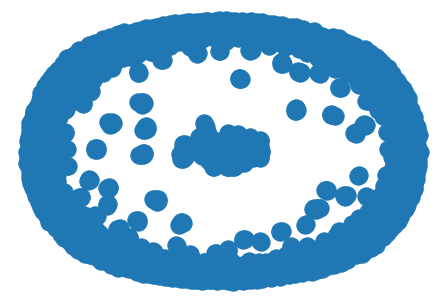

In [127]:
interactions_2000_up_pd.draw_network_interactions(True)

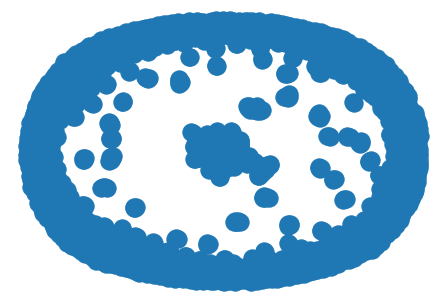

In [128]:
interactions_2000_up_pd.save_draw_network_interactions(True, "interaction_network_2000_up_pd.png")
interactions_2000_up_pd.save_adjacency_matrix(True, "adjacency_matrix_2000_up_pd.csv")
interactions_2000_up_pd.save_graph(True, "graph_2000_up_pd.adjlist")

Посмотрим на сеть взаимодействий белков, соответствующих генам пониженной экспрессии.

In [129]:
start_time = time.time()

interactions_2000_down_pd = Interactions_dataframe(signature, 9606, 0.4)
interactions_2000_down_pd.get_interactions_as_adjacency_matrix(False)
Graph_2000_down_pd = interactions_2000_down_pd.get_interactions_as_graph(False)

print("--- %s seconds ---" % (time.time() - start_time))

print("number nodes:", len(list(Graph_2000_down_pd.nodes)))
print("number edges:", len(list(Graph_2000_down_pd.edges)))

--- 18.597793102264404 seconds ---
number nodes: 2000
number edges: 1441


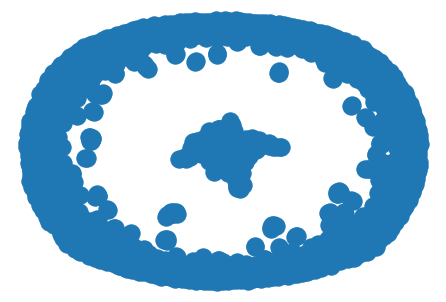

In [131]:
interactions_2000_down_pd.draw_network_interactions(False)

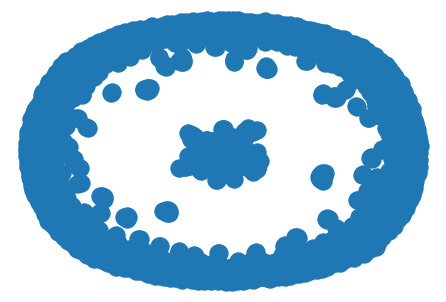

In [132]:
interactions_2000_down_pd.save_draw_network_interactions(False, "interaction_network_2000_down_pd.png")
interactions_2000_down_pd.save_adjacency_matrix(False, "adjacency_matrix_2000_down_pd.csv")
interactions_2000_down_pd.save_graph(False, "graph_2000_down_pd.adjlist")

Напишем аналогичный класс, используя numpy arrays для создания матрицы смежности и графа.

In [116]:
class Interactions_numpy_array:
    """
    class Interactions is designed to represent STRING protein-protein interaction network in different forms: adjacency matrix, graph
    
    Attributes
    ----------
    signature: a tuple with list of genes with increased expression and list of genes with decreased expression
    up_genes : a list of genes with increased expression
    down_genes: a list of genes with decreased expression
    species: NCBI taxon identifiers (e.g. Human is 9606)
    experimental_score_threshold: threshold for combined score. It's computed by combining the probabilities from 
    the different evidence channels and corrected for the probability of randomly observing an interaction.

    Methods
    -------
    API_request(expression_change)
        requests STRING interaction network for multiple proteins
        
    get_interactions_as_adjacency_matrix(expression_change)
        builds an adjacency matrix for the interaction network

    get_interactions_as_graph(expression_change)
        builds a graph for the interaction network
        
    draw_network_ineractions(expression_change)
        draw the interaction network
    
    save_draw_network_ineractions(expression_change, file_name)
    
    save_adjacency_matrix(expression_change, file_name)
        save adjacency_matrix in csv file format
        
    save_graph(expression_change, file_name)
        save graph in multiline adjacency list format to path
    """
    def __init__(self, signature, species, experimental_score_threshold):
        self.signature = signature
        self.up_genes = signature[0]
        self.down_genes = signature[1]
        self.species = species
        self.experimental_score_threshold = experimental_score_threshold
        
    def API_request(self, expression_change):
        if expression_change:
            gene_set = self.up_genes
        else:
            gene_set = self.down_genes
            
        string_api_url = "https://string-db.org/api"
        output_format = "tsv-no-header"
        method = "network"
        
        request_url = "/".join([string_api_url, output_format, method])
        params = {

            "identifiers" : "%0d".join(gene_set), # your protein
            "species" : self.species, # species NCBI identifier 
            "caller_identity" : "www.awesome_app.org" # your app name

        }
        
        response = requests.post(request_url, data = params)
        return response
    
    def get_interactions_as_adjacency_matrix(self, expression_change):
        if expression_change:
            gene_set = self.up_genes
        else:
            gene_set = self.down_genes

        np_array_as_adjacency_matrix= np.zeros(shape=(len(gene_set), len(gene_set)))
        array_numbers = range(len(gene_set))
        dict_genes = dict(zip(gene_set, array_numbers))
        
        response = self.API_request(expression_change)
        try:
            response.raise_for_status()
            for line in response.text.strip().split("\n"):

                l = line.strip().split("\t")
                p1, p2 = l[2], l[3]

                ## filter the interaction according to experimental score
                experimental_score = float(l[10])
                if experimental_score > self.experimental_score_threshold:
                    if ((p1 in gene_set) & (p2 in gene_set)):
                        np_array_as_adjacency_matrix[dict_genes[p1], dict_genes[p2]] = 1
                        np_array_as_adjacency_matrix[dict_genes[p2], dict_genes[p1]] = 1
            return np_array_as_adjacency_matrix
        except HTTPError as http_err:
            print(f'some problems with querying the STRING database. More precisely HTTP error occurred: {http_err}') 
            print(f'answer database STRING: {response.text}')
            
    def get_interactions_as_graph(self, expression_change):
        array = self.get_interactions_as_adjacency_matrix(expression_change)
        G = nx.from_numpy_array(array)
        return G
    
    def draw_network_interactions(self, expression_change):
        G = self.get_interactions_as_graph(expression_change)
        nx.draw(G)
        
    def save_draw_network_interactions(self, expression_change, file_name):
        self.draw_network_interactions(expression_change)
        plt.savefig(file_name, format = 'png', dpi = 300)
        
    def save_adjacency_matrix(self, expression_change, name_file):
        array = self.get_interactions_as_adjacency_matrix(expression_change)
        np.save(name_file, array)
        
    def save_graph(self, expression_change, name_file):
        G = self.get_interactions_as_graph(expression_change)
        nx.write_multiline_adjlist(G, name_file)

Посмотрим на сеть взаимодействий белков, соответствующих генам повышенной экспрессии.

In [117]:
start_time = time.time()

interactions_2000_up_np = Interactions_numpy_array(signature, 9606, 0.4)
interactions_2000_up_np.get_interactions_as_adjacency_matrix(True)
Graph_2000_up_np = interactions_2000_up_np.get_interactions_as_graph(True)

print("--- %s seconds ---" % (time.time() - start_time))

print("number nodes:", len(list(Graph_2000_up_np.nodes)))
print("number edges:", len(list(Graph_2000_up_np.edges)))

--- 17.329354286193848 seconds ---
number nodes: 2000
number edges: 523


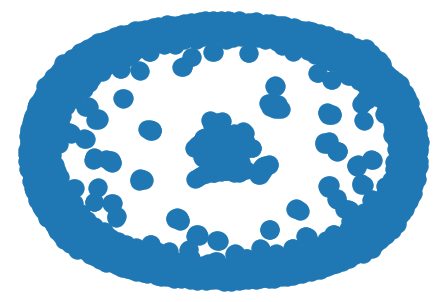

In [118]:
interactions_2000_up_np.draw_network_interactions(True)

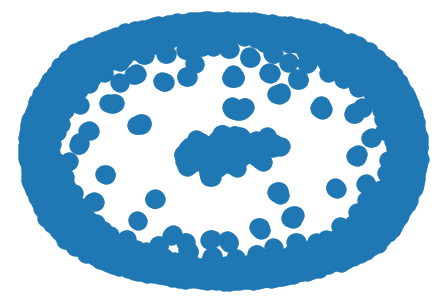

In [134]:
interactions_2000_up_np.save_draw_network_interactions(True, "interaction_network_2000_up_np.png")
interactions_2000_up_np.save_adjacency_matrix(True, "adjacency_matrix_2000_up_np")
interactions_2000_up_np.save_graph(True, "graph_2000_up_np.adjlist")

Посмотрим на сеть взаимодействий белков, соответствующих генам пониженной экспрессии.

In [121]:
start_time = time.time()

interactions_2000_down_np = Interactions_numpy_array(signature, 9606, 0.4)
interactions_2000_down_np.get_interactions_as_adjacency_matrix(False)
Graph_2000_down_np = interactions_2000_down_np.get_interactions_as_graph(False)

print("--- %s seconds ---" % (time.time() - start_time))

print("number nodes:", len(list(Graph_2000_down_np.nodes)))
print("number edges:", len(list(Graph_2000_down_np.edges)))

--- 17.7979416847229 seconds ---
number nodes: 2000
number edges: 1441


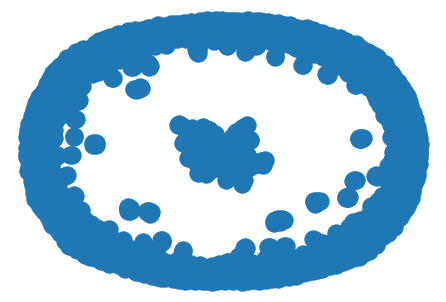

In [122]:
interactions_2000_down_np.draw_network_interactions(False)

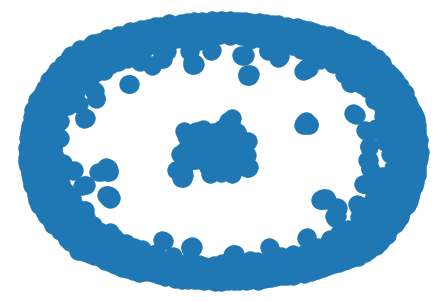

In [133]:
interactions_2000_down_np.save_draw_network_interactions(False, "interaction_network_2000_down_np.png")
interactions_2000_down_np.save_adjacency_matrix(False, "adjacency_matrix_2000_down_np")
interactions_2000_down_np.save_graph(False, "graph_2000_down_np.adjlist")